<a href="https://colab.research.google.com/github/aaradhygarg/TA2_IDS_Aaradhy_AI/blob/main/TA2_AI_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d hassan06/nslkdd --unzip


In [ ]:
from google.colab import files

In [ ]:
!pip install -q seaborn kaggle xgboost

In [ ]:
import os
if os.path.exists('kaggle.json'):
  os.makedirs('/root/.kaggle', exist_ok=True)
  !cp kaggle.json /root/.kaggle/
  !chmod 600 /root/.kaggle/kaggle.json
  print('kaggle.json copied to /root/.kaggle/')
else:
  print('No kaggle.json found in the working directory. If you want auto-download, upload kaggle.json.')

No kaggle.json found in the working directory. If you want auto-download, upload kaggle.json.


In [ ]:
!ls -lh

total 22M
-rw-r--r-- 1 root root 3.3M Nov 25 20:47 KDDTest+.txt
-rw-r--r-- 1 root root  19M Nov 25 20:48 KDDTrain+.txt
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data


Loading files: {'train': PosixPath('KDDTrain+.txt'), 'test': PosixPath('KDDTest+.txt')}
Train shape: (125973, 43) Test shape: (22544, 43)
Preprocessing done. Features: 122

Training Logistic Regression...
Training Random Forest...
Training XGBoost...

Evaluating logistic...
              precision    recall  f1-score   support

           0       0.92      0.62      0.74     12833
           1       0.65      0.93      0.76      9711

    accuracy                           0.75     22544
   macro avg       0.78      0.77      0.75     22544
weighted avg       0.80      0.75      0.75     22544



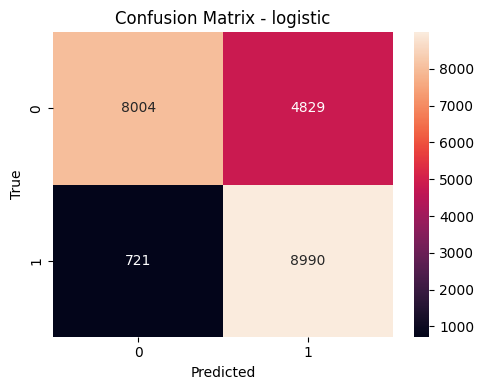

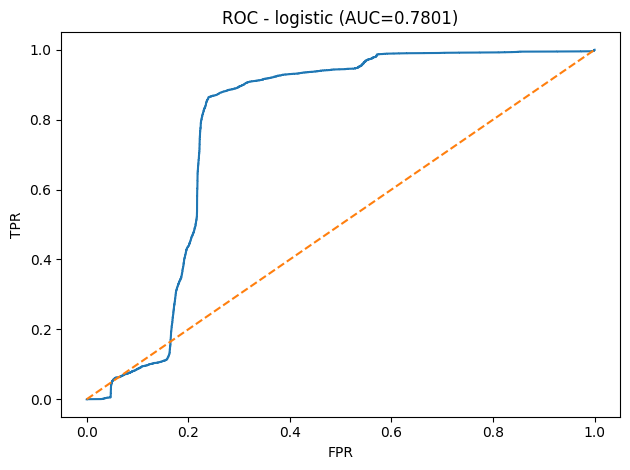


Evaluating random_forest...
              precision    recall  f1-score   support

           0       0.97      0.61      0.75     12833
           1       0.65      0.97      0.78      9711

    accuracy                           0.77     22544
   macro avg       0.81      0.79      0.77     22544
weighted avg       0.83      0.77      0.76     22544



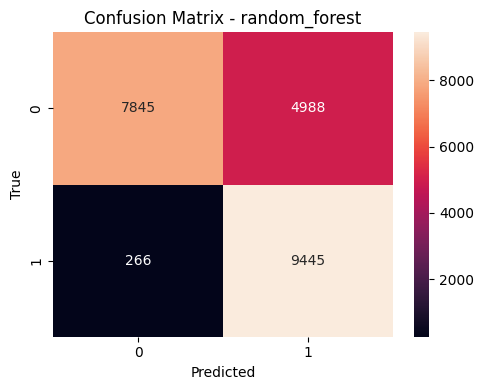

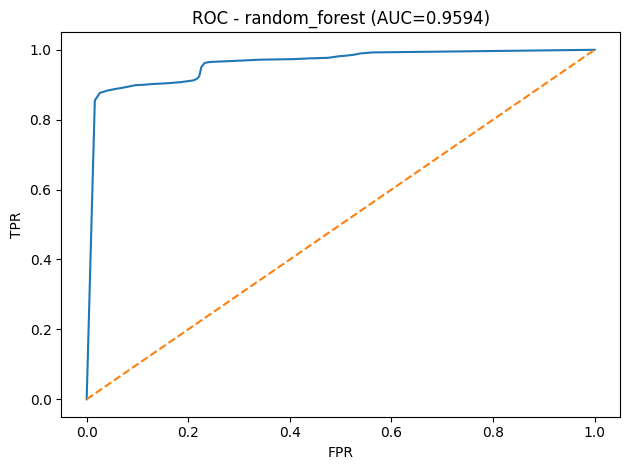


Evaluating xgboost...
              precision    recall  f1-score   support

           0       0.97      0.64      0.77     12833
           1       0.67      0.97      0.80      9711

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544



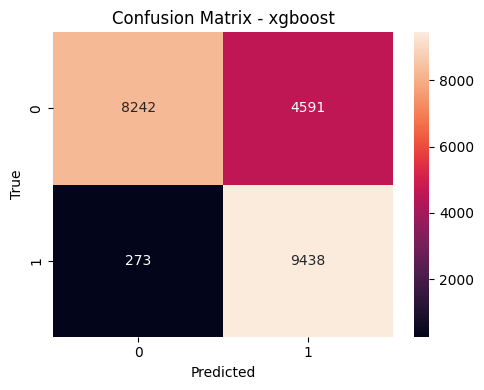

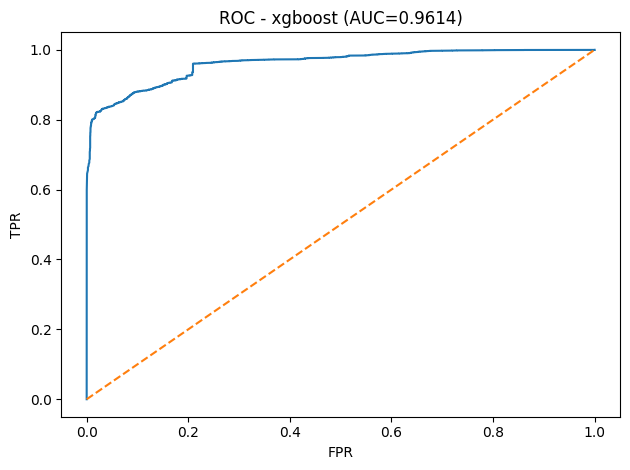


All artifacts saved to /content/out
Done.


In [ ]:

import sys
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Column names for NSL-KDD (KDDTrain+.txt / KDDTest+.txt)
KDD_COLUMNS = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes",
    "land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
    "num_compromised","root_shell","su_attempted","num_root","num_file_creations",
    "num_shells","num_access_files","num_outbound_cmds","is_host_login",
    "is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
    "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
    "srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "label","difficulty"
]

# Utility to find train/test files
def find_files():
    p = Path('.')
    candidates = {}
    for name in ["KDDTrain+.txt","KDDTest+.txt","KDDTrain+.csv","KDDTest+.csv"]:
        if (p / name).exists():
            if 'Train' in name:
                candidates['train'] = p / name
            else:
                candidates['test'] = p / name
    return candidates

files = find_files()
if 'train' not in files or 'test' not in files:
    raise FileNotFoundError('KDDTrain+.txt or KDDTest+.txt not found. Upload them to Colab or run the kaggle download cell.')

print('Loading files:', files)
df_train = pd.read_csv(files['train'], names=KDD_COLUMNS, header=None)
df_test = pd.read_csv(files['test'], names=KDD_COLUMNS, header=None)
print('Train shape:', df_train.shape, 'Test shape:', df_test.shape)

# Simple binary mapping: normal vs attack
for df in [df_train, df_test]:
    df['label'] = df['label'].str.strip()

y_train = df_train['label'].apply(lambda x: 'normal' if x=='normal' else 'attack')
y_test  = df_test['label'].apply(lambda x: 'normal' if x=='normal' else 'attack')

X_train = df_train.drop(columns=['label','difficulty'], errors='ignore')
X_test  = df_test.drop(columns=['label','difficulty'], errors='ignore')

# Categorical columns
cat_cols = ['protocol_type','service','flag']
cat_cols = [c for c in cat_cols if c in X_train.columns]
X_train = pd.get_dummies(X_train, columns=cat_cols)
X_test = pd.get_dummies(X_test, columns=cat_cols)

# Align columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print('Preprocessing done. Features:', X_train.shape[1])

# Train simple models
print('\nTraining Logistic Regression...')
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_s, y_train_enc)

print('Training Random Forest...')
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train_s, y_train_enc)

# Optionally train XGBoost if installed
try:
    import xgboost as xgb
    print('Training XGBoost...')
    xgb_clf = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, n_estimators=100)
    xgb_clf.fit(X_train_s, y_train_enc)
    has_xgb = True
except Exception as e:
    print('XGBoost not installed or failed to import; skipping XGBoost. Error:', e)
    has_xgb = False

# Evaluate helper
out_dir = Path('/content/out')
out_dir.mkdir(parents=True, exist_ok=True)

models = {'logistic': lr, 'random_forest': rf}
if has_xgb:
    models['xgboost'] = xgb_clf

summary = []
for name, model in models.items():
    print(f'\nEvaluating {name}...')
    y_pred = model.predict(X_test_s)
    report = classification_report(y_test_enc, y_pred)
    print(report)
    cm = confusion_matrix(y_test_enc, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(out_dir / f'confusion_{name}.png')
    plt.show()

    # ROC AUC (binary)
    try:
        y_prob = model.predict_proba(X_test_s)[:,1]
        auc = roc_auc_score(y_test_enc, y_prob)
        fpr, tpr, _ = roc_curve(y_test_enc, y_prob)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1],'--')
        plt.title(f'ROC - {name} (AUC={auc:.4f})')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.tight_layout()
        plt.savefig(out_dir / f'roc_{name}.png')
        plt.show()
    except Exception as e:
        print('Could not compute ROC for', name, '->', e)

    # save model
    dump(model, out_dir / f'model_{name}.joblib')
    summary.append({'model': name})

# Save preprocessor objects
from joblib import dump
dump(scaler, out_dir / 'scaler.joblib')
dump(le, out_dir / 'label_encoder.joblib')

print('\nAll artifacts saved to /content/out')

# Optional: copy to Google Drive (uncomment if you want to save results to Drive)
# from google.colab import drive
# drive.mount('/content/drive')
# !cp -r /content/out /content/drive/MyDrive/

print('Done.')